Compression based on: \\
[1] R. Prabhavalkar, O. Alsharif, A. Bruguier, and L. McGraw, “On the compression of recurrent neural networks with an application to LVCSR acoustic modeling for embedded speech recognition,” in 2016 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2016, pp. 5970–5974. https://ieeexplore.ieee.org/abstract/document/7472823/

# Compressed LSTM

Define CLSTMCell based on LSTMCell and LSTM layer from Keras version 2.2.4

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [2]:
import warnings

import tensorflow as tf
from tensorflow.keras.layers import Layer, RNN, Dropout
from tensorflow.keras import activations, initializers, regularizers, constraints


class CLSTMCell(Layer):
    """Cell class for the Compressed LSTM layer based on keras LSTM.

    # Arguments
        units: Positive integer, dimensionality of the output space.
        rank: Positive integer, dimensionality of the compressed output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hard sigmoid (`hard_sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).x
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Setting it to true will also force `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al.]
            (http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units, rank,
                 activation='tanh',
                 recurrent_activation='hard_sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=True,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=1,
                 **kwargs):
        super(CLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.unit_forget_bias = unit_forget_bias

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = (self.rank, self.units)
        self.output_size = self.rank

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(input_dim, self.units * 4),
            name='kernel',
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint)

        self.projection = self.add_weight(
            shape=(self.units, self.rank),
            name='projection',
            initializer=self.recurrent_initializer
        )

        self.recurrent_kernel = self.add_weight(
            shape=(self.rank, self.units * 4),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            if self.unit_forget_bias:
                def bias_initializer(_, *args, **kwargs):
                    return tf.concat([
                        self.bias_initializer((self.units,), *args, **kwargs),
                        tf.ones((self.units,), *args, **kwargs),
                        self.bias_initializer((self.units * 2,), *args, **kwargs),
                    ], axis=0)
            else:
                bias_initializer = self.bias_initializer
            self.bias = self.add_weight(
                shape=(self.units * 4,),
                name='bias',
                initializer=bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1]  # previous carry state

        if self.implementation == 1:
            if 0 < self.dropout < 1:
                inputs_i = tf.nn.dropout(inputs, rate=self.dropout)
                inputs_f = tf.nn.dropout(inputs, rate=self.dropout)
                inputs_c = tf.nn.dropout(inputs, rate=self.dropout)
                inputs_o = tf.nn.dropout(inputs, rate=self.dropout)
            else:
                inputs_i = inputs_f = inputs_c = inputs_o = inputs

            x_i = tf.matmul(inputs_i, self.kernel[:, :self.units])
            x_f = tf.matmul(inputs_f, self.kernel[:, self.units:self.units * 2])
            x_c = tf.matmul(inputs_c, self.kernel[:, self.units * 2:self.units * 3])
            x_o = tf.matmul(inputs_o, self.kernel[:, self.units * 3:])

            if self.use_bias:
                x_i = tf.nn.bias_add(x_i, self.bias[:self.units])
                x_f = tf.nn.bias_add(x_f, self.bias[self.units:self.units * 2])
                x_c = tf.nn.bias_add(x_c, self.bias[self.units * 2:self.units * 3])
                x_o = tf.nn.bias_add(x_o, self.bias[self.units * 3:])

            if 0 < self.recurrent_dropout < 1:
                h_tm1_i = tf.nn.dropout(h_tm1, rate=self.recurrent_dropout)
                h_tm1_f = tf.nn.dropout(h_tm1, rate=self.recurrent_dropout)
                h_tm1_c = tf.nn.dropout(h_tm1, rate=self.recurrent_dropout)
                h_tm1_o = tf.nn.dropout(h_tm1, rate=self.recurrent_dropout)
            else:
                h_tm1_i = h_tm1_f = h_tm1_c = h_tm1_o = h_tm1

            i = self.recurrent_activation(
                x_i + tf.matmul(h_tm1_i, self.recurrent_kernel[:, :self.units]))
            f = self.recurrent_activation(
                x_f + tf.matmul(h_tm1_f, self.recurrent_kernel[:, self.units:self.units * 2]))
            c = f * c_tm1 + i * self.activation(
                x_c + tf.matmul(h_tm1_c, self.recurrent_kernel[:, self.units * 2:self.units * 3]))
            o = self.recurrent_activation(
                x_o + tf.matmul(h_tm1_o, self.recurrent_kernel[:, self.units * 3:]))

        else:
            if 0 < self.dropout < 1:
                inputs = tf.nn.dropout(inputs, rate=self.dropout)

            z = tf.matmul(inputs, self.kernel)
            if 0 < self.recurrent_dropout < 1:
                h_tm1 = tf.nn.dropout(h_tm1, rate=self.recurrent_dropout)

            z += tf.matmul(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                z = tf.nn.bias_add(z, self.bias)

            z0, z1, z2, z3 = tf.split(z, 4, axis=1)

            i = self.recurrent_activation(z0)
            f = self.recurrent_activation(z1)
            c = f * c_tm1 + i * self.activation(z2)
            o = self.recurrent_activation(z3)

        h = o * self.activation(c)
        h = tf.matmul(h, self.projection)

        return h, [h, c]

    def get_config(self):
        config = {
            'units': self.units,
            'rank': self.rank,
            'activation': activations.serialize(self.activation),
            'recurrent_activation': activations.serialize(self.recurrent_activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'unit_forget_bias': self.unit_forget_bias,
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint),
            'dropout': self.dropout,
            'recurrent_dropout': self.recurrent_dropout,
            'implementation': self.implementation
        }
        base_config = super(CLSTMCell, self).get_config()
        return {**base_config, **config}


"""Long Short-Term Memory layer - Hochreiter 1997.

    # Arguments
        units: Positive integer, dimensionality of the output space.
        rank: Positive integer, dimensionality of the compressed output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hard sigmoid (`hard_sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Setting it to true will also force `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al.]
            (http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.

    # References
        - [Long short-term memory]
          (http://www.bioinf.jku.at/publications/older/2604.pdf)
        - [Learning to forget: Continual prediction with LSTM]
          (http://www.mitpressjournals.org/doi/pdf/10.1162/089976600300015015)
        - [Supervised sequence labeling with recurrent neural networks]
          (http://www.cs.toronto.edu/~graves/preprint.pdf)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

class CLSTM(RNN):

    def __init__(self, units, rank,
                 activation='tanh',
                 recurrent_activation='hard_sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=True,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=1,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')

        cell = CLSTMCell(units,
                         rank,
                         activation=activation,
                         recurrent_activation=recurrent_activation,
                         use_bias=use_bias,
                         kernel_initializer=kernel_initializer,
                         recurrent_initializer=recurrent_initializer,
                         unit_forget_bias=unit_forget_bias,
                         bias_initializer=bias_initializer,
                         kernel_regularizer=kernel_regularizer,
                         recurrent_regularizer=recurrent_regularizer,
                         bias_regularizer=bias_regularizer,
                         kernel_constraint=kernel_constraint,
                         recurrent_constraint=recurrent_constraint,
                         bias_constraint=bias_constraint,
                         dropout=dropout,
                         recurrent_dropout=recurrent_dropout,
                         implementation=implementation)
        super(CLSTM, self).__init__(cell,
                                    return_sequences=return_sequences,
                                    return_state=return_state,
                                    go_backwards=go_backwards,
                                    stateful=stateful,
                                    unroll=unroll,
                                    **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, sequences, training=None, initial_state=None):
        return super(CLSTM, self).call(sequences,
                                      training=training,
                                      initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def rank(self):
        return self.cell.rank

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def unit_forget_bias(self):
        return self.cell.unit_forget_bias

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'rank': self.rank,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(CLSTM, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

# Compress Weights

In [3]:
import numpy as np

def get_projection_rank(sigma, threshold):
    """
    :param sigma: Singular values (SV) from singular value decomposition (SVD) ordered from large SV to small SV
    :param threshold: Percentage of SV taken into account based on energy of SV
    :return: Rank of projection matrix
    """
    k = 0
    while (np.sum(sigma[:k] ** 2) / np.sum(sigma ** 2) < threshold):
        k += 1
    return k


def get_projection_matrices(weight_matrix, threshold):
    """
    Applies SVD to the `weight_matrix` and returns truncated `projection_matrix` and `back_projection_matrix` based on
    the provided `threshold`.
    :param weight_matrix: weight_matrix to be compressed
    :param threshold: compression threshold
    :return: [projection_matrix, back_projection_matrix] for provided weight_matrix
    """
    u, s, vh = np.linalg.svd(weight_matrix, full_matrices=True)
    rank = get_projection_rank(s, threshold)
    ut = u[:, :rank]
    st = np.diag(s[:rank])
    vht = vh[:rank, :]
    projection_matrix = ut @ st
    back_projection_matrix = vht
    return [projection_matrix, back_projection_matrix]


def compress_weights(weights_to_be_compressed, compression_threshold):
    """
    Compresses the weights of LSTM layers, which then can be passed to the CLSTM Layers.
    :param weights_to_be_compressed: List of weights for each LSTM layer to be compressed provide as
    [kernel, recurrent_kernel, bias]. The last element of the list should be the weights of the layer that follows the
    last LSTM Layer starting with the kernel weights.
    :param compression_threshold: compression level
    :return: Returns list of compressed weights kernel_back_projection, projection_matrix, recurrent_kernel, bias
    """
    number_of_layers = len(weights_to_be_compressed)
    bias_list = []
    kernel_list = []
    recurrent_kernel_list = []

    kernel_back_projection_list = []
    projection_matrix_list = []
    recurrent_kernel_back_projection_list = []

    compressed_weight_list = []

    # Reading weights from weights_to_be_compressed by layer
    for layer in range(number_of_layers-1):
        kernel_list.append(weights_to_be_compressed[layer][0])
        recurrent_kernel_list.append(weights_to_be_compressed[layer][1])
        bias_list.append(weights_to_be_compressed[layer][2])
    # Append kernel of following layer
    kernel_list.append(weights_to_be_compressed[number_of_layers-1][0])

    # Compressing weights in LSTM layers
    for layer in range(number_of_layers-1):
        if layer == 0:
            kernel_back_projection_list.append(kernel_list[0])
        else:
            kernel_back_projection, _, _, _ = \
                np.linalg.lstsq(projection_matrix_list[layer - 1], kernel_list[layer], rcond=None)
            kernel_back_projection_list.append(kernel_back_projection)
        projection_matrix, recurrent_kernel_back_projection_matrix = \
            get_projection_matrices(recurrent_kernel_list[layer], compression_threshold)

        projection_matrix_list.append(projection_matrix)
        recurrent_kernel_back_projection_list.append(recurrent_kernel_back_projection_matrix)

        compressed_weight_list.append(
            [kernel_back_projection_list[layer],
             projection_matrix_list[layer],
             recurrent_kernel_back_projection_list[layer],
             bias_list[layer]]
        )

    # Compressing kernel of the layer following the LSTM to be compressed
    following_layer_kernel_back_projection, _, _, _ = \
        np.linalg.lstsq(projection_matrix_list[number_of_layers-2], kernel_list[number_of_layers-1], rcond=None)
    following_layer_weights = [following_layer_kernel_back_projection]
    following_layer_weights.extend(weights_to_be_compressed[number_of_layers-1][1:])
    compressed_weight_list.append(following_layer_weights)

    return compressed_weight_list



# Experiment

In [ ]:
# from compress_weights import compress_weights
# from clstm import CLSTM
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input


# Definition of uncompressed example model
x = Input(shape=[64, 6])
lstm_1 = layers.LSTM(units=64, return_sequences=True)(x)
lstm_2 = layers.LSTM(units=64, return_sequences=True)(lstm_1)
lstm_3 = layers.LSTM(units=64, return_sequences=True)(lstm_2)
lstm_4 = layers.LSTM(units=64, return_sequences=True)(lstm_3)
output = layers.TimeDistributed(layers.Dense(units=1), name='dense')(lstm_4)
model = Model(
    inputs=[x],
    outputs=[output],
    name='example_model'
)
model.summary()

# In this example we do not train the example_model.
# In general the compressed LSTMs are only used at inference or for curriculum training
# with the compressed weights of a previously trained model with LSTMs instead of CLSTMs.


# Getting weights from (trained) model
weights = model.get_weights()
# Reorganizing weights by layer
weights_by_layer = [weights[0:3], weights[3:6], weights[6:9], weights[9:12], weights[12:]]
# Compressing weights
compressed_weights = compress_weights(weights_by_layer, 1)


# Definition of compressed example model
clstm_1 = CLSTM(
    units=64,
    rank=compressed_weights[0][1].shape[1],
    return_sequences=True,
    name='clstm_1',
)(x)
clstm_2 = CLSTM(
    units=64,
    rank=compressed_weights[1][1].shape[1],
    return_sequences=True,
    name='clstm_2'
)(clstm_1)
clstm_3 = CLSTM(
    units=64,
    rank=compressed_weights[2][1].shape[1],
    return_sequences=True,
    name='clstm_3'
)(clstm_2)
clstm_4 = CLSTM(
    units=64,
    rank=compressed_weights[3][1].shape[1],
    return_sequences=True,
    name='clstm_4'
)(clstm_3)
output_2 = layers.TimeDistributed(layers.Dense(units=1), name='cdense')(clstm_4)
compressed_model = Model(
    inputs=[x],
    outputs=[output_2],
    name='compressed_example_model'
)


# Loading compressed weights into compressed example model
clstm_1_layer = compressed_model.get_layer(name='clstm_1')
clstm_1_layer.set_weights(compressed_weights[0])
clstm_2_layer = compressed_model.get_layer(name='clstm_2')
clstm_2_layer.set_weights(compressed_weights[1])
clstm_3_layer = compressed_model.get_layer(name='clstm_3')
clstm_3_layer.set_weights(compressed_weights[2])
clstm_3_layer = compressed_model.get_layer(name='clstm_4')
clstm_3_layer.set_weights(compressed_weights[3])
cdense_layer = compressed_model.get_layer(name='cdense')
cdense_layer.set_weights(compressed_weights[4])

compressed_model.summary()


Model: "example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (TimeDistributed)              │ (None, 64, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,313 (458.25 KB)

 Trainable params: 117,313 (458.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "compressed_example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ clstm_1 (CLSTM)                      │ (None, 64, 64)              │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ clstm_2 (CLSTM)                      │ (None, 64, 64)              │          37,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ clstm_3 (CLSTM)                      │ (None, 64, 64)              │          37,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ clstm_4 (CLSTM)                      │ (None, 64, 64)              │          37,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cdense (TimeDistributed)             │ (None, 64, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,697 (522.25 KB)

 Trainable params: 133,697 (522.25 KB)

 Non-trainable params: 0 (0.00 B)

# LSTM Model

In [4]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd

def normalize(train):
    train = train.drop(["date"], axis=1)
    features = train.drop(["OT"], axis=1)

    # Normalize the features except 'OT'
    features_normalized = features.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

    # Combine normalized features with the 'OT' column
    train_norm = features_normalized.join(train["OT"])
    return train_norm

def buildTrain(train, pastDay=30, futureDay=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
      X_train.append(np.array(train.iloc[i:i+pastDay]))
      Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["OT"]))
    return np.array(X_train), np.array(Y_train)

def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

# Load your data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FYP/LSTM/ETTh1.csv')

features_normalized = normalize(data)

# Create sequences
seq_length = 24  # Sequence length
X, y = buildTrain(features_normalized, seq_length, 1)

X, y = shuffle(X, y)

val_rate = 0.1
X_train, Y_train, X_val, Y_val = splitData(X, y, val_rate)
# print(X_train[0], Y_train[0])
print(X_train.shape, Y_train.shape)

(15656, 24, 7) (15656, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def MyLSTM(shape):
  print(shape)
  model = Sequential()
  model.add(tf.keras.Input(shape))
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64))
  model.add(Dense(1))
  model.summary()
  return model

# Define the LSTM model
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
print("Device:", device)
model = MyLSTM([X_train.shape[1],X_train.shape[2]])

# Compile the model
optimizer = Adam(learning_rate=2e-3)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, epochs=1000, batch_size=64, validation_data=(X_val, Y_val), callbacks=[callback])

Device: /GPU:0
[24, 7]


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 24, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,569 (459.25 KB)

 Trainable params: 117,569 (459.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


ValueError: 'Original LSTM' is not a valid root scope name. A root scope name has to match the following pattern: ^[A-Za-z0-9.][A-Za-z0-9_.\\/>-]*$

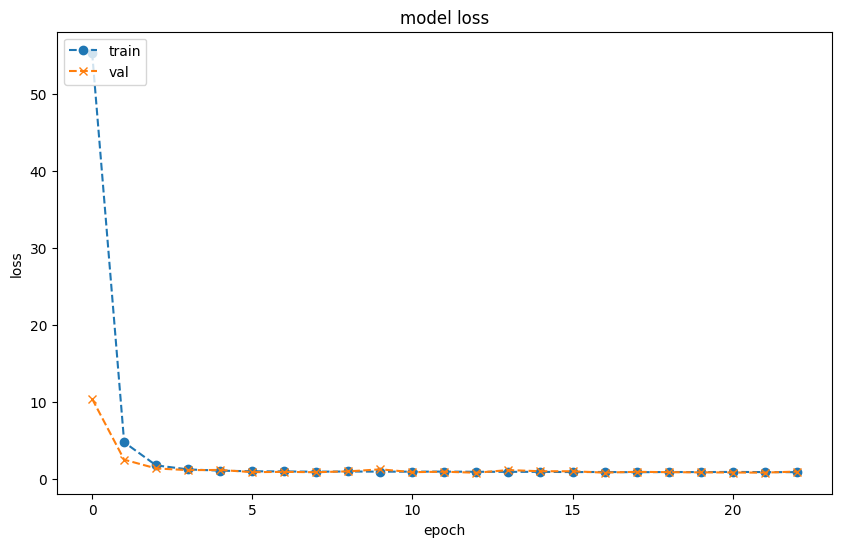

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], marker='o', linestyle='--')
plt.plot(history.history['val_loss'], marker='x', linestyle='--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
MSE: 0.9015441535441141, 10% error acc: 0.8090856814261069


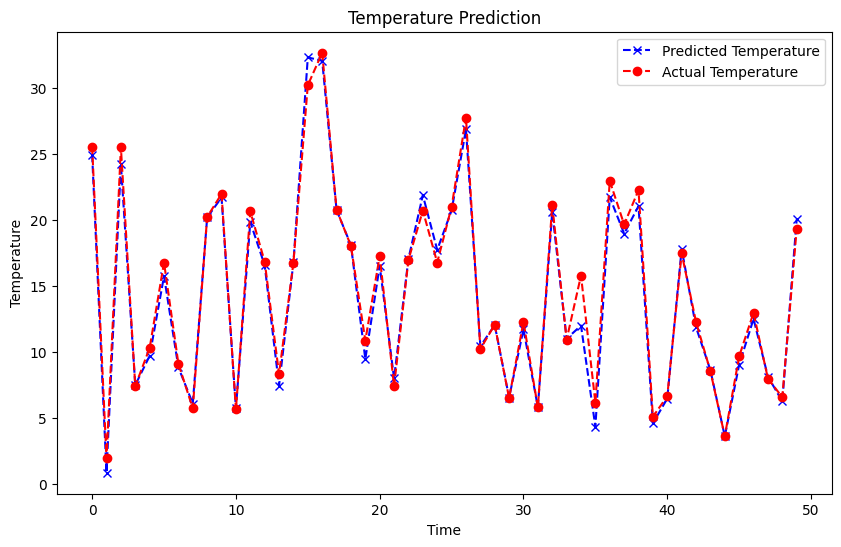

In [ ]:
# Make predictions
predictions = model.predict(X_val)

def percent_acc(pre, act, percent):
    err = np.abs(pre-act)/(act+1e-20)
    acc = np.sum(err < (percent/100.0))/err.shape[0]
    return acc

# Flatten the predictions and actual values
predictions = predictions.flatten()
actuals = Y_val.flatten()
mse = np.mean((predictions - actuals) ** 2)
percent_margin = 10
print(f'MSE: {mse}, {percent_margin}% error acc: {percent_acc(predictions, actuals, percent_margin)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(predictions[0:50], color='blue', marker='x', linestyle='--', label='Predicted Temperature')
plt.plot(actuals[0:50], color='red', marker='o', linestyle='--', label='Actual Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/FYP/Model_Compression/Saved_models/lstm.keras')

Model: "Original_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,569 (459.25 KB)

 Trainable params: 117,569 (459.25 KB)

 Non-trainable params: 0 (0.00 B)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Original Model: MSE: 0.9015441535441141, 20% error acc: 0.9321449108683151, Runtime 805.92529296875 ms


Model: "Compressed_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ clstm_1 (CLSTM)                      │ (None, 24, 15)              │           6,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ clstm_2 (CLSTM)                      │ (None, 24, 32)              │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ clstm_3 (CLSTM)                      │ (None, 24, 34)              │          19,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ clstm_4 (CLSTM)                      │ (None, 39)                  │          21,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cdense (Dense)                       │ (None, 1)                   │              40 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,992 (242.16 KB)

 Trainable params: 61,992 (242.16 KB)

 Non-trainable params: 0 (0.00 B)

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
compression ratio: 0.8, MSE: 0.9015441535441141, 20% error acc: 0.7487061529614721, Runtime: 5490.3017578125 ms


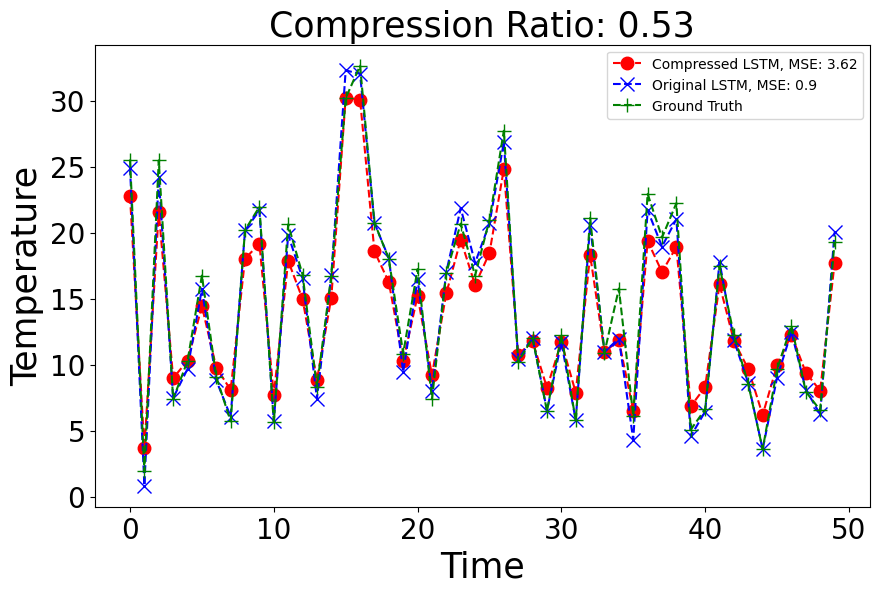

In [9]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def percent_acc(pre, act, percent):
    err = np.abs(pre-act)/(act+1e-20)
    acc = np.sum(err < (percent/100.0))/err.shape[0]
    return acc

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/FYP/Model_Compression/Saved_models/lstm.keras", custom_objects=None, compile=False)
model.name = 'Original_LSTM'
model.summary()

# Make predictions
start = time.time()*1000
predictions = model.predict(X_val)
end = time.time()*1000

# Flatten the predictions and actual values
predictions = predictions.flatten()
actuals = Y_val.flatten()
mse = np.mean((predictions - actuals) ** 2)
percent_margin = 20
print(f'Original Model: MSE: {mse}, {percent_margin}% error acc: {percent_acc(predictions, actuals, percent_margin)}, Runtime {end-start} ms')

# Count total parameters
total_params = sum(layer.count_params() for layer in model.layers)
# print(f'Total parameters: {total_params}')


for cr in [0.8]:
    # Getting weights from (trained) model
    weights = model.get_weights()
    # Reorganizing weights by layer
    weights_by_layer = [weights[0:3], weights[3:6], weights[6:9], weights[9:12], weights[12:]]
    # Compressing weights
    compressed_weights = compress_weights(weights_by_layer, cr)


    # Definition of compressed example model
    def CMyLSTM(shape):
        model = Sequential()
        model.add(tf.keras.Input(shape))
        model.add(CLSTM(64, rank=compressed_weights[0][1].shape[1], return_sequences=True, name='clstm_1'))
        model.add(CLSTM(64, rank=compressed_weights[1][1].shape[1], return_sequences=True, name='clstm_2'))
        model.add(CLSTM(64, rank=compressed_weights[2][1].shape[1], return_sequences=True, name='clstm_3'))
        model.add(CLSTM(64, rank=compressed_weights[3][1].shape[1], name='clstm_4'))
        model.add(Dense(1, name='cdense'))
        model.name = 'Compressed_LSTM'
        model.summary()
        return model

    compressed_model = CMyLSTM([24,7])


    # Loading compressed weights into compressed example model
    clstm_1_layer = compressed_model.get_layer(name='clstm_1')
    clstm_1_layer.set_weights(compressed_weights[0])
    clstm_2_layer = compressed_model.get_layer(name='clstm_2')
    clstm_2_layer.set_weights(compressed_weights[1])
    clstm_3_layer = compressed_model.get_layer(name='clstm_3')
    clstm_3_layer.set_weights(compressed_weights[2])
    clstm_3_layer = compressed_model.get_layer(name='clstm_4')
    clstm_3_layer.set_weights(compressed_weights[3])
    cdense_layer = compressed_model.get_layer(name='cdense')
    cdense_layer.set_weights(compressed_weights[4])

    # Make predictions
    start = time.time()*1000
    cpredictions = compressed_model.predict(X_val)
    end = time.time()*1000

    # Flatten the predictions and actual values
    cpredictions = cpredictions.flatten()
    actuals = Y_val.flatten()
    cmse = np.mean((cpredictions - actuals) ** 2)
    percent_margin = 20
    print(f'compression ratio: {cr}, MSE: {mse}, {percent_margin}% error acc: {percent_acc(cpredictions, actuals, percent_margin)}, Runtime: {end-start} ms')
    ctotal_params = sum(layer.count_params() for layer in compressed_model.layers)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(cpredictions[0:50], color='red', marker='o', markersize=9, linestyle='--', label=f'Compressed LSTM, MSE: {round(cmse,2)}')
    plt.plot(predictions[0:50], color='blue', marker='x', markersize=10, linestyle='--', label=f'Original LSTM, MSE: {round(mse,2)}')
    plt.plot(actuals[0:50], color='green', marker='+', markersize=10, linestyle='--', label='Ground Truth')
    plt.title(f'Compression Ratio: {round(ctotal_params/total_params,2)}', fontsize=25)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Temperature', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=10)
    plt.show()